In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predicting-heart-disease-risk-using-clinical-var/Heart_Disease_Prediction.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os

import random
import json
from pandas.io.json import json_normalize
from scipy import stats
from datetime import datetime
from sklearn import model_selection

#gradient boosting 

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz

# podemos desmarcar esta linea junto con la celda de visualización del decision tree.
import graphviz

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# model selection e hiperparameters optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedKFold, KFold
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score

In [3]:
def plot_num(dataframe, column, target_column):
    
    print("Atributo: ",column)
    with sns.color_palette("Set2") :
         plt.figure(figsize = (15,5))

    ax1 = plt.subplot(1,3,1)
    ax1 = dataframe[column].plot(kind= 'hist', bins = 50)

    ax2 = plt.subplot(1,3,2)
    ax2 = sns.boxplot(data = dataframe, x = target_column, y = column)

    ax3 = plt.subplot(1,3,3)
    ax3_1 = dataframe[dataframe[target_column] == 0][column].plot(kind = 'hist', bins = 25, alpha = .5)      
    ax3_2 = dataframe[dataframe[target_column] == 1][column].plot(kind = 'hist', bins = 25, alpha = .5)
    ax3 = ax3_1 
    ax3 = ax3_2
    ax3.legend(labels=["No","Yes"], loc='right')

    plt.show()

IMPORTAMOS DATOS

In [4]:
df=pd.read_csv('/kaggle/input/predicting-heart-disease-risk-using-clinical-var/Heart_Disease_Prediction.csv')

In [5]:
df.drop('index',axis=1,inplace=True)

In [6]:
df

Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0     70    1                4  130          322             0            2   
1     67    0                3  115          564             0            2   
2     57    1                2  124          261             0            0   
3     64    1                4  128          263             0            0   
4     74    0                2  120          269             0            2   
..   ...  ...              ...  ...          ...           ...          ...   
265   52    1                3  172          199             1            0   
266   44    1                2  120          263             0            0   
267   56    0                2  140          294             0            2   
268   57    1                4  140          192             0            0   
269   67    1                4  160          286             0            2   

     Max HR  Exercise angina  ST depression  Slope of ST  \
0       109                0            2.4            2   
1       160                0            1.6            2   
2       141                0            0.3            1   
3       105                1            0.2            2   
4       121                1            0.2            1   
..      ...              ...            ...          ...   
265     162                0            0.5            1   
266     173                0            0.0            1   
267     153                0            1.3            2   
268     148                0            0.4            2   
269     108                1            1.5            2   

     Number of vessels fluro  Thallium Heart Disease  
0                          3         3      Presence  
1                          0         7       Absence  
2                          0         7      Presence  
3                          1         7       Absence  
4                          1         3       Absence  
..                       ...       ...           ...  
265                        0         7       Absence  
266                        0         7       Absence  
267                        0         3       Absence  
268                        0         6       Absence  
269                        3         3      Presence  

[270 rows x 14 columns]

-The attributes are
-Age, 
-Sex, 
-Chest Pain Type,
-BP (blood pressure),
-Cholesterol level,
-FBS over 120 (fasting blood sugar --> glucemia en ayunas),
-EKG Results (electrocardiogram results), 
-Max HR (maximum heart rate),
-Exercise Angina status, 
-ST Depression ( depression of ST segment on ECG)(El segmento ST muestra cuando se contrae el ventrículo, pero no hay electricidad fluyendo a través de él. La cardiopatía isquémica es la causa más frecuente de elevación o de descenso del segmento ST.) , 
-Slope of ST(slope of the ST segment on the ECG), 
-Number of Vessels Fluroscopy (number of vessels seen on fluoroscopy. La fluoroscopia muestra la sangre -circulando por las arterias. Se usa para diagnosticar y tratar algunas afecciones cardíacas. )
-Thallium Stress test results: The results of this test will tell you about the flow of blood to your heart through your coronary arteries (prueba de esfuerzo)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    object 
dtypes: float64(1), int64(12), 

In [8]:
porc_disease=df['Heart Disease'].value_counts()[1]/len(df)
porc_disease

0.4444444444444444

In [9]:
df.describe().T

count        mean        std    min    25%    50%  \
Age                      270.0   54.433333   9.109067   29.0   48.0   55.0   
Sex                      270.0    0.677778   0.468195    0.0    0.0    1.0   
Chest pain type          270.0    3.174074   0.950090    1.0    3.0    3.0   
BP                       270.0  131.344444  17.861608   94.0  120.0  130.0   
Cholesterol              270.0  249.659259  51.686237  126.0  213.0  245.0   
FBS over 120             270.0    0.148148   0.355906    0.0    0.0    0.0   
EKG results              270.0    1.022222   0.997891    0.0    0.0    2.0   
Max HR                   270.0  149.677778  23.165717   71.0  133.0  153.5   
Exercise angina          270.0    0.329630   0.470952    0.0    0.0    0.0   
ST depression            270.0    1.050000   1.145210    0.0    0.0    0.8   
Slope of ST              270.0    1.585185   0.614390    1.0    1.0    2.0   
Number of vessels fluro  270.0    0.670370   0.943896    0.0    0.0    0.0   
Thallium                 270.0    4.696296   1.940659    3.0    3.0    3.0   

                           75%    max  
Age                       61.0   77.0  
Sex                        1.0    1.0  
Chest pain type            4.0    4.0  
BP                       140.0  200.0  
Cholesterol              280.0  564.0  
FBS over 120               0.0    1.0  
EKG results                2.0    2.0  
Max HR                   166.0  202.0  
Exercise angina            1.0    1.0  
ST depression              1.6    6.2  
Slope of ST                2.0    3.0  
Number of vessels fluro    1.0    3.0  
Thallium                   7.0    7.0

In [10]:
lista_var=df.columns

In [11]:
lista_var

Index(['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120',
       'EKG results', 'Max HR', 'Exercise angina', 'ST depression',
       'Slope of ST', 'Number of vessels fluro', 'Thallium', 'Heart Disease'],
      dtype='object')

informacion respecto a la distribución de las variables

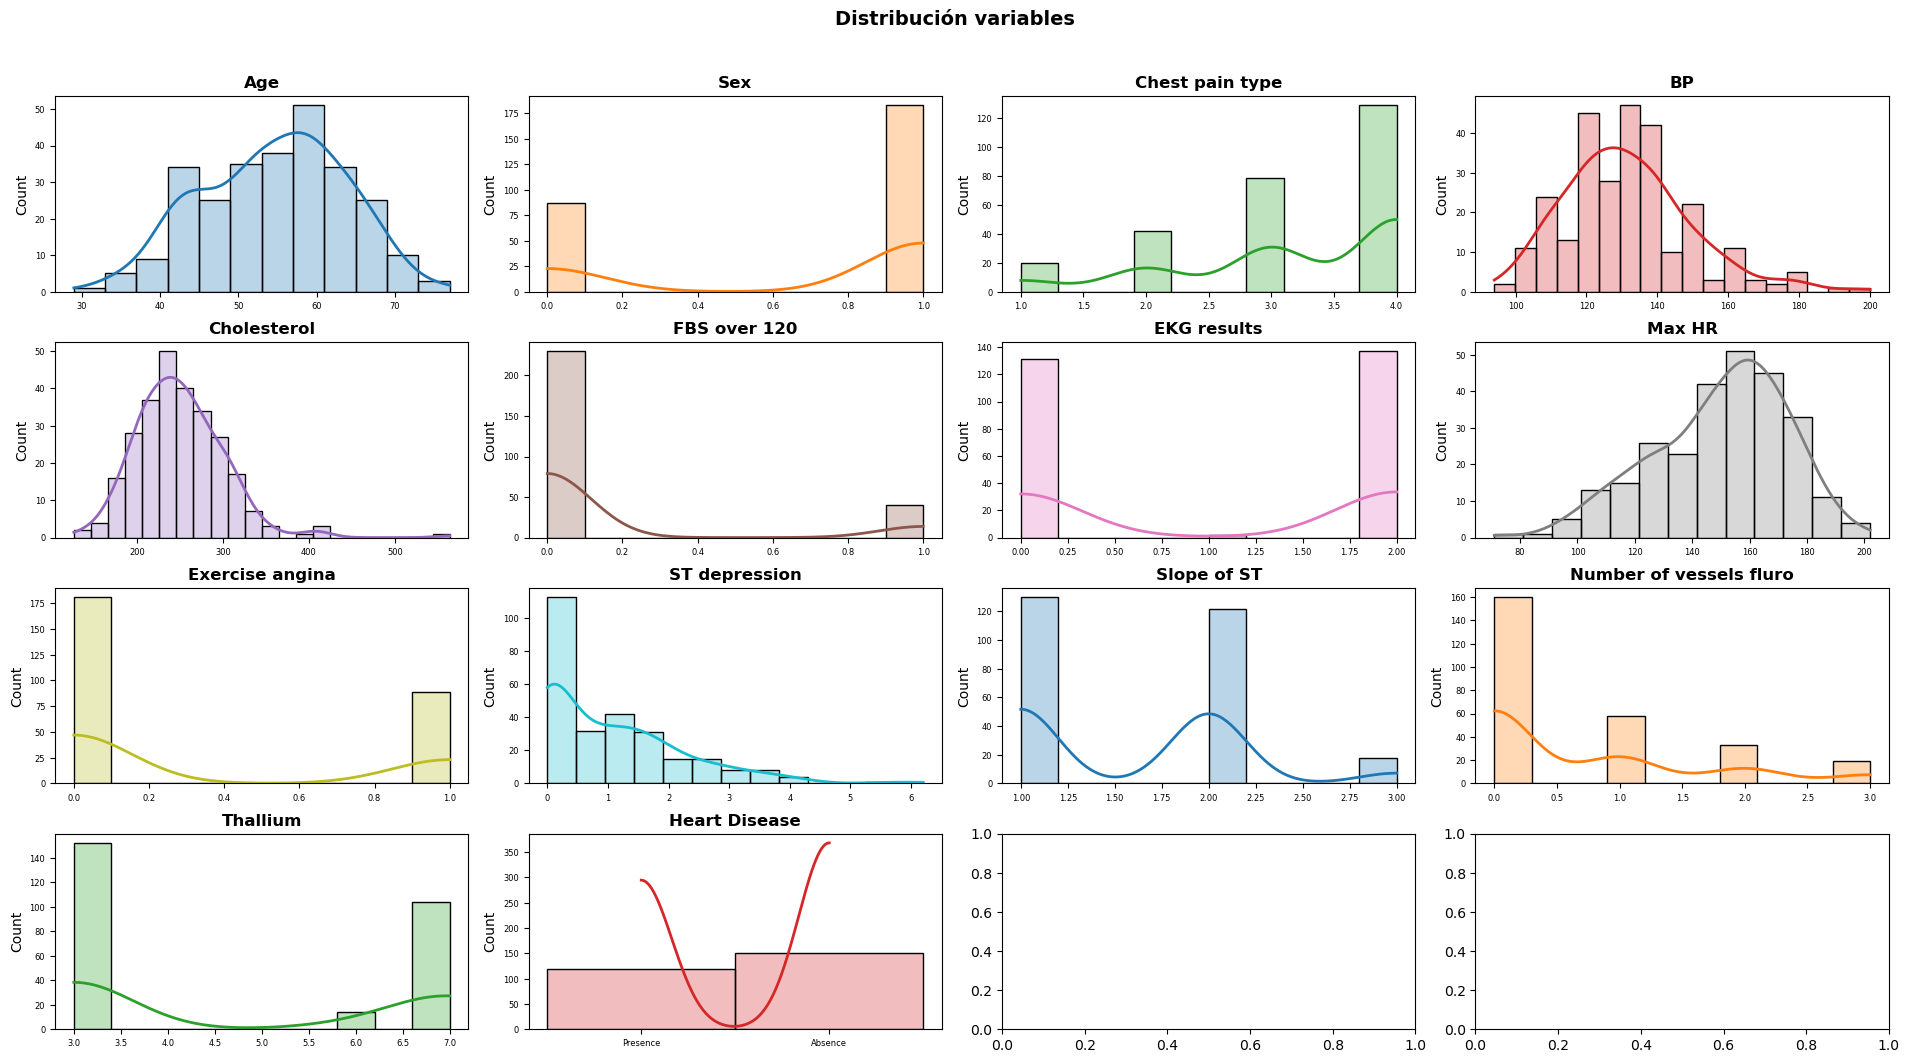

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(19.2, 10.8))
axes = axes.flat
for i, colum in enumerate(lista_var):
    sns.histplot(
        data    = df,
        x       = colum,
        stat    = "count",
        kde     =True, #función de densidad de probabilidad 
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
        
    )
    axes[i].set_title(colum, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables', fontsize = 14, fontweight = "bold");

TARGET

In [13]:
TARGET='Heart Disease'

In [14]:
df[TARGET].describe()

count         270
unique          2
top       Absence
freq          150
Name: Heart Disease, dtype: object

Análisis univaraible

In [15]:
df[TARGET].value_counts()

Absence     150
Presence    120
Name: Heart Disease, dtype: int64

In [16]:
df[TARGET]=np.where(df[TARGET]=='Absence',0,1)

In [17]:
df[[TARGET]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Heart Disease  270 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


ANALISIS DE VARIABLES

In [18]:
lista_var=lista_var.to_list()

In [19]:
lista_var.pop(-1)

'Heart Disease'

Atributo:  Age


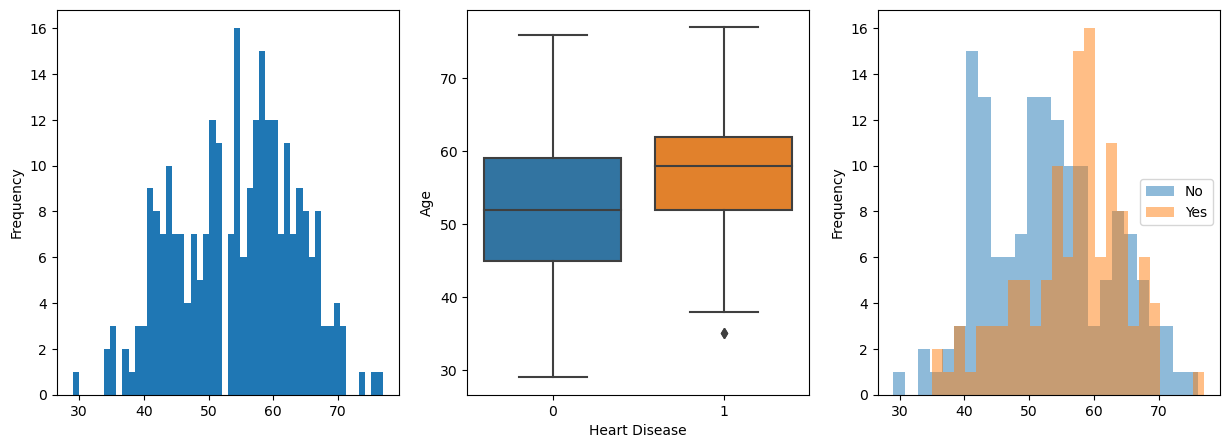

Atributo:  Sex


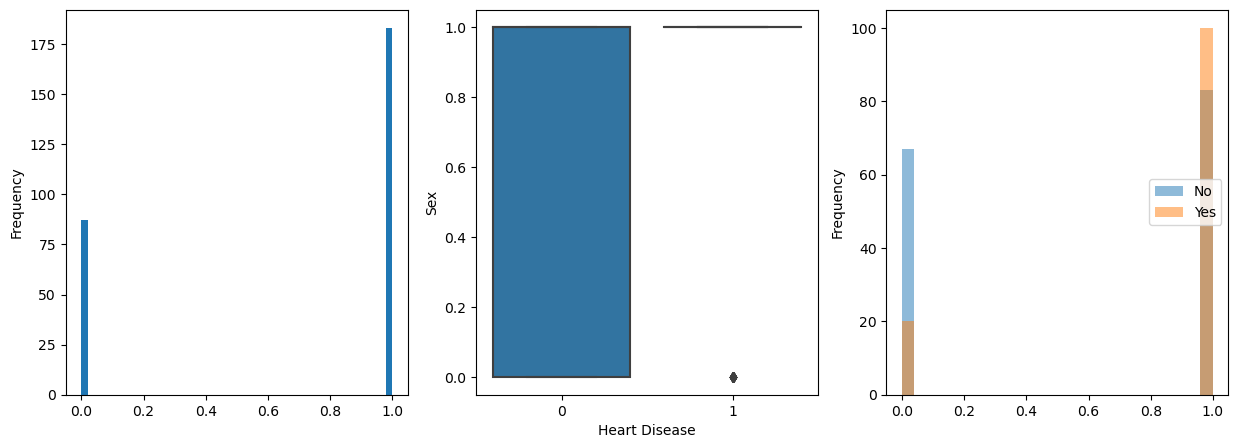

Atributo:  Chest pain type


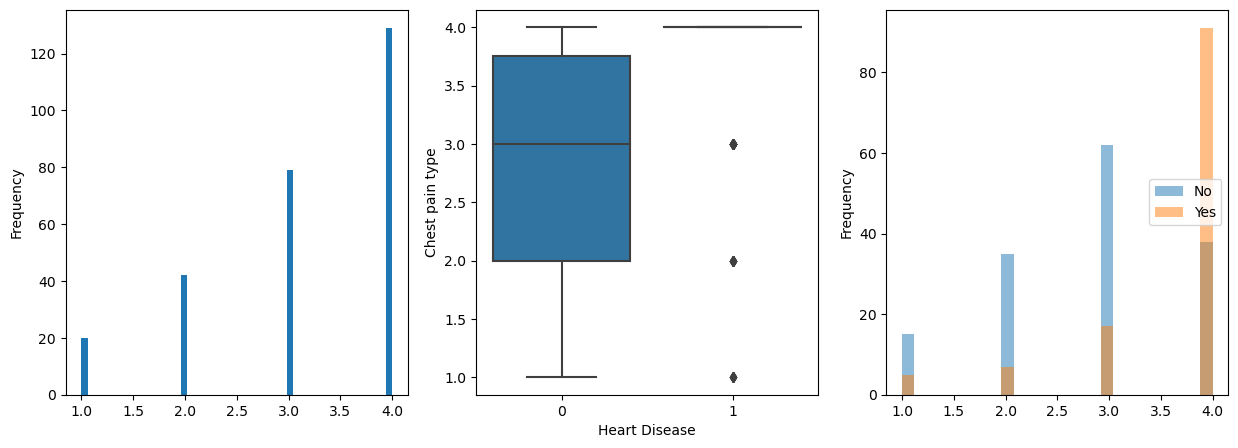

Atributo:  BP


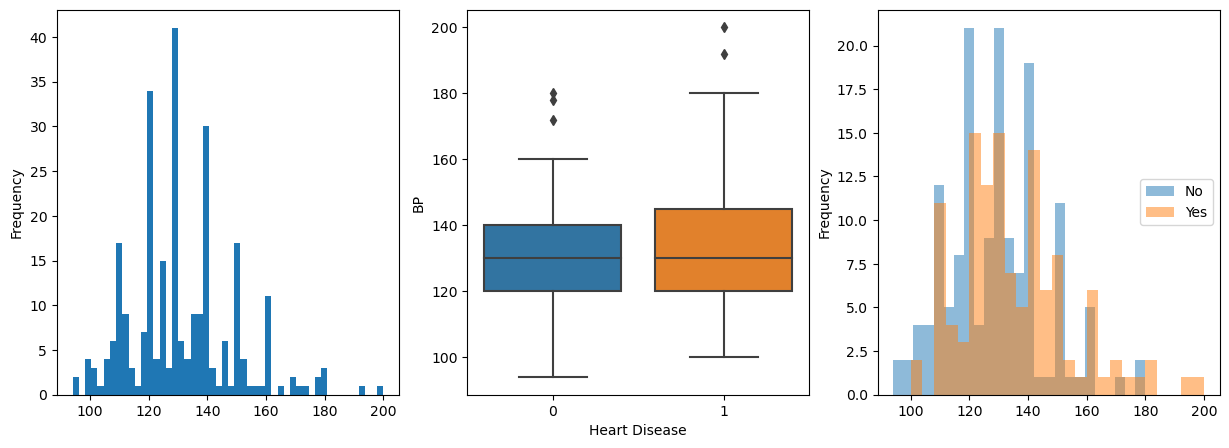

Atributo:  Cholesterol


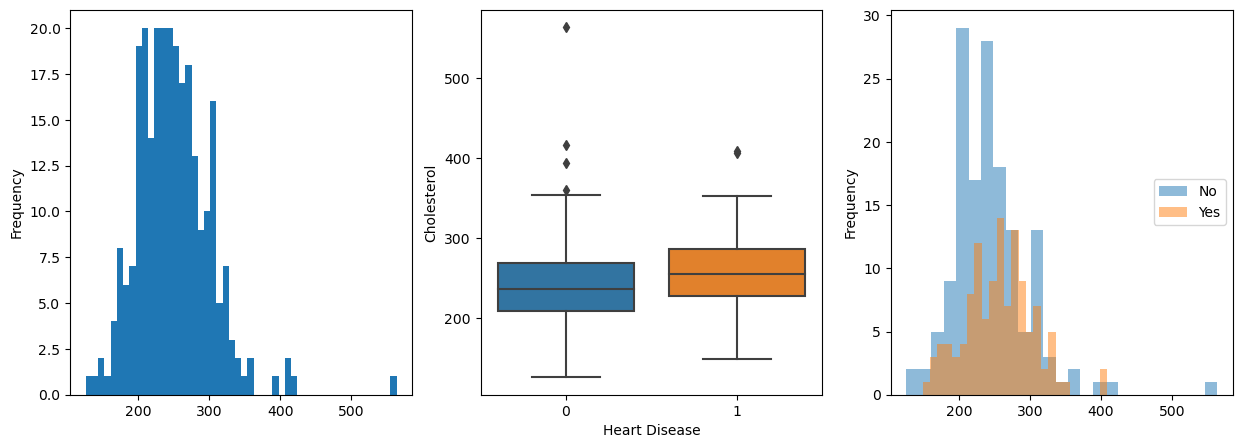

Atributo:  FBS over 120


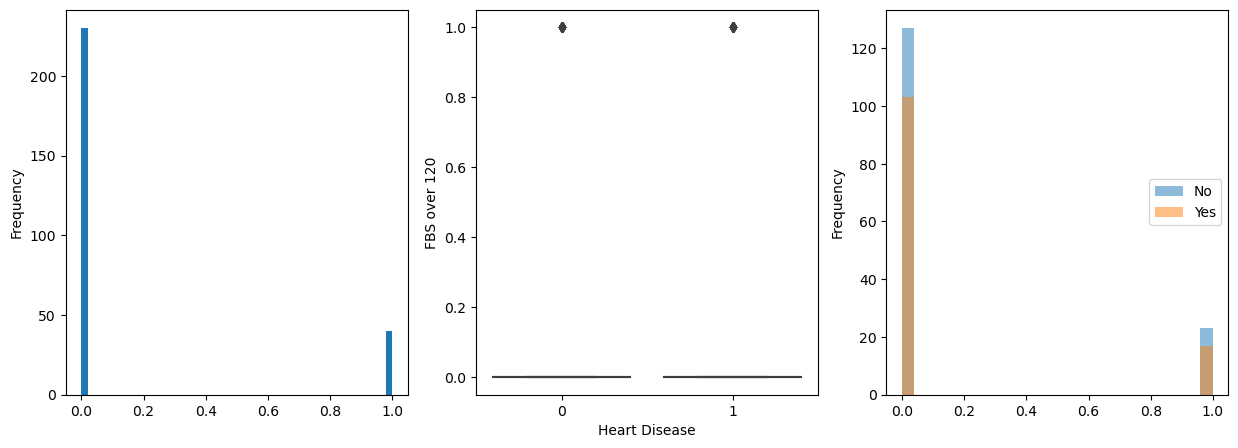

Atributo:  EKG results


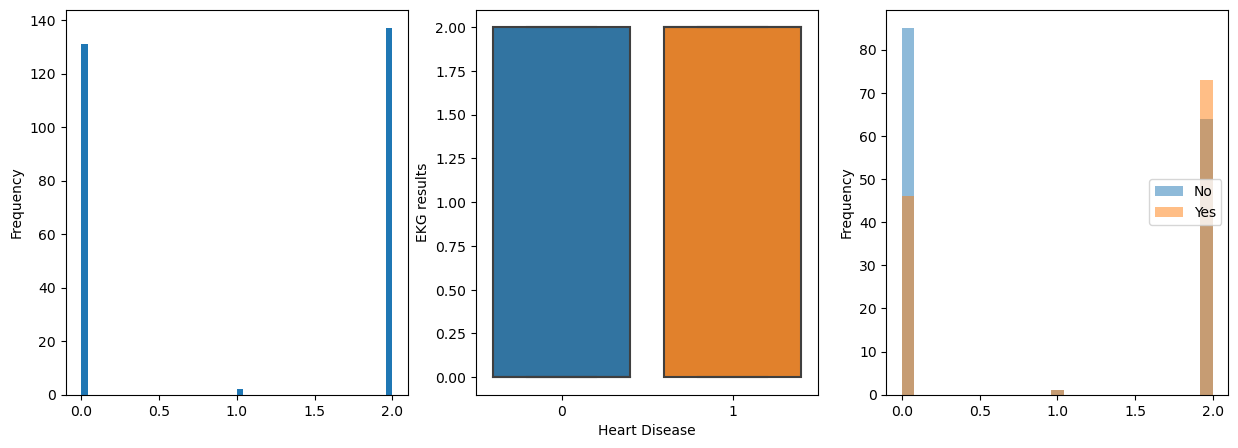

Atributo:  Max HR


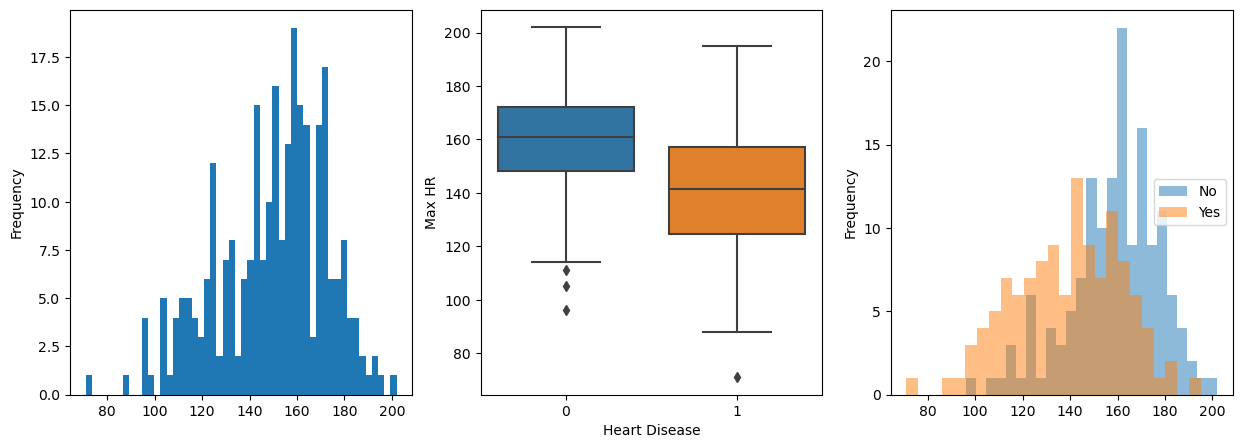

Atributo:  Exercise angina


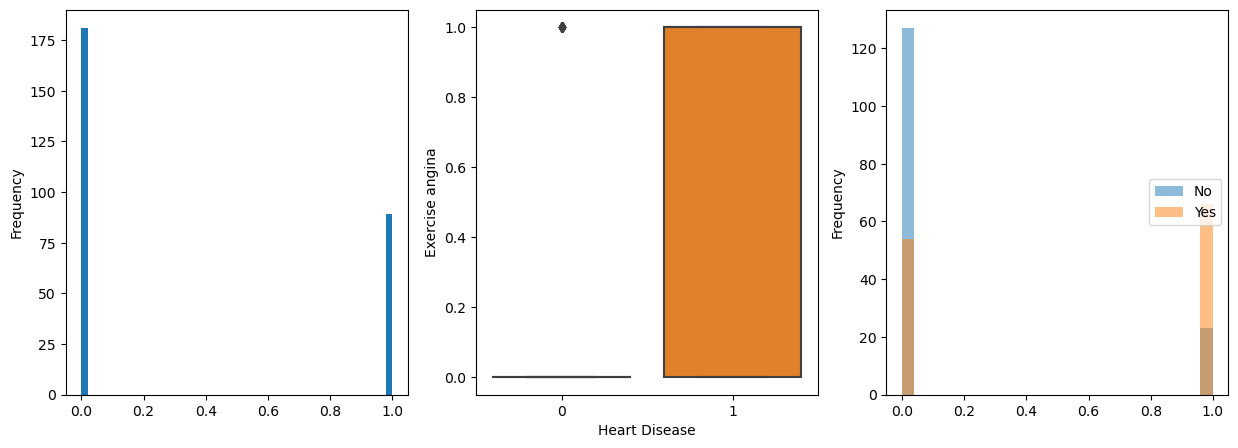

Atributo:  ST depression


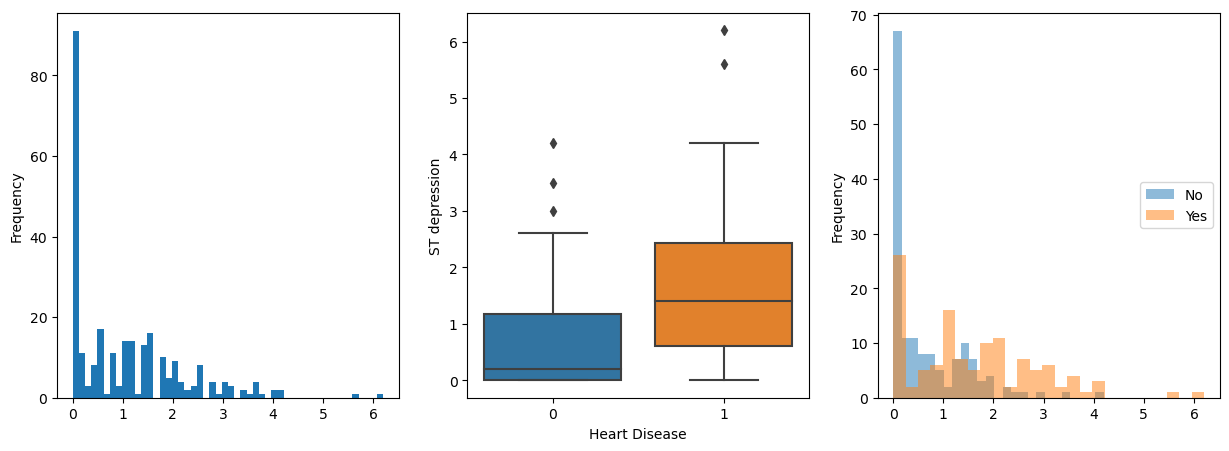

Atributo:  Slope of ST


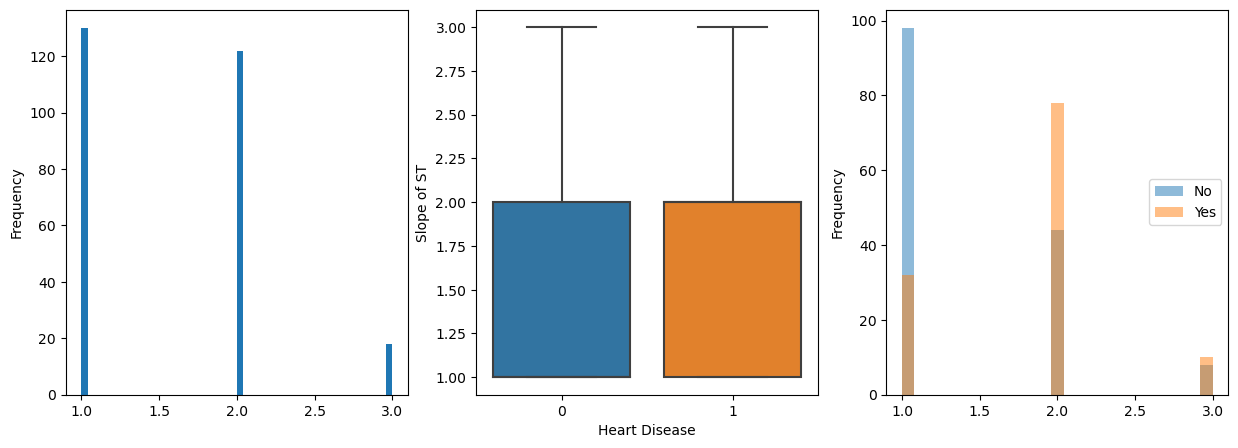

Atributo:  Number of vessels fluro


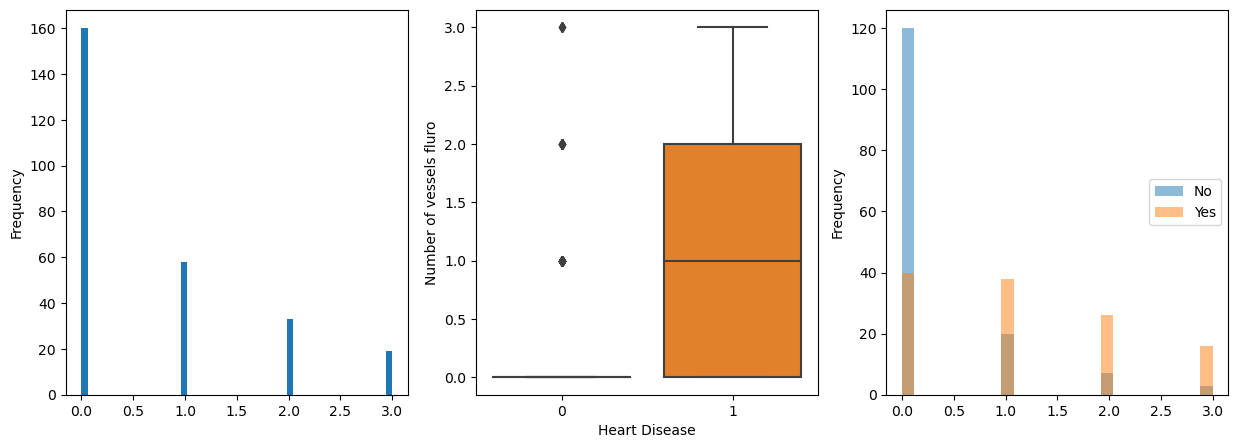

Atributo:  Thallium


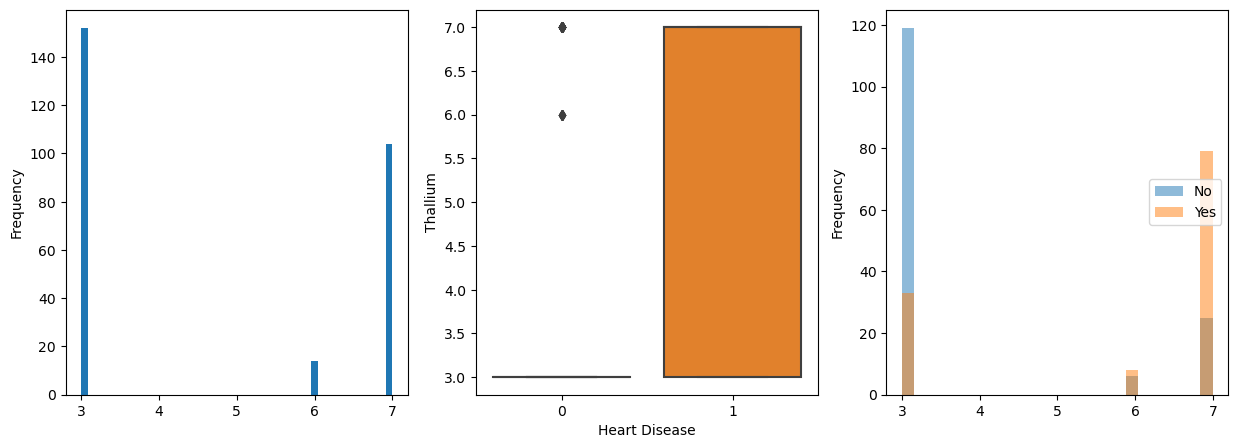

In [20]:
for i in lista_var:
    plot_num(df,i,TARGET)


Correlaciones

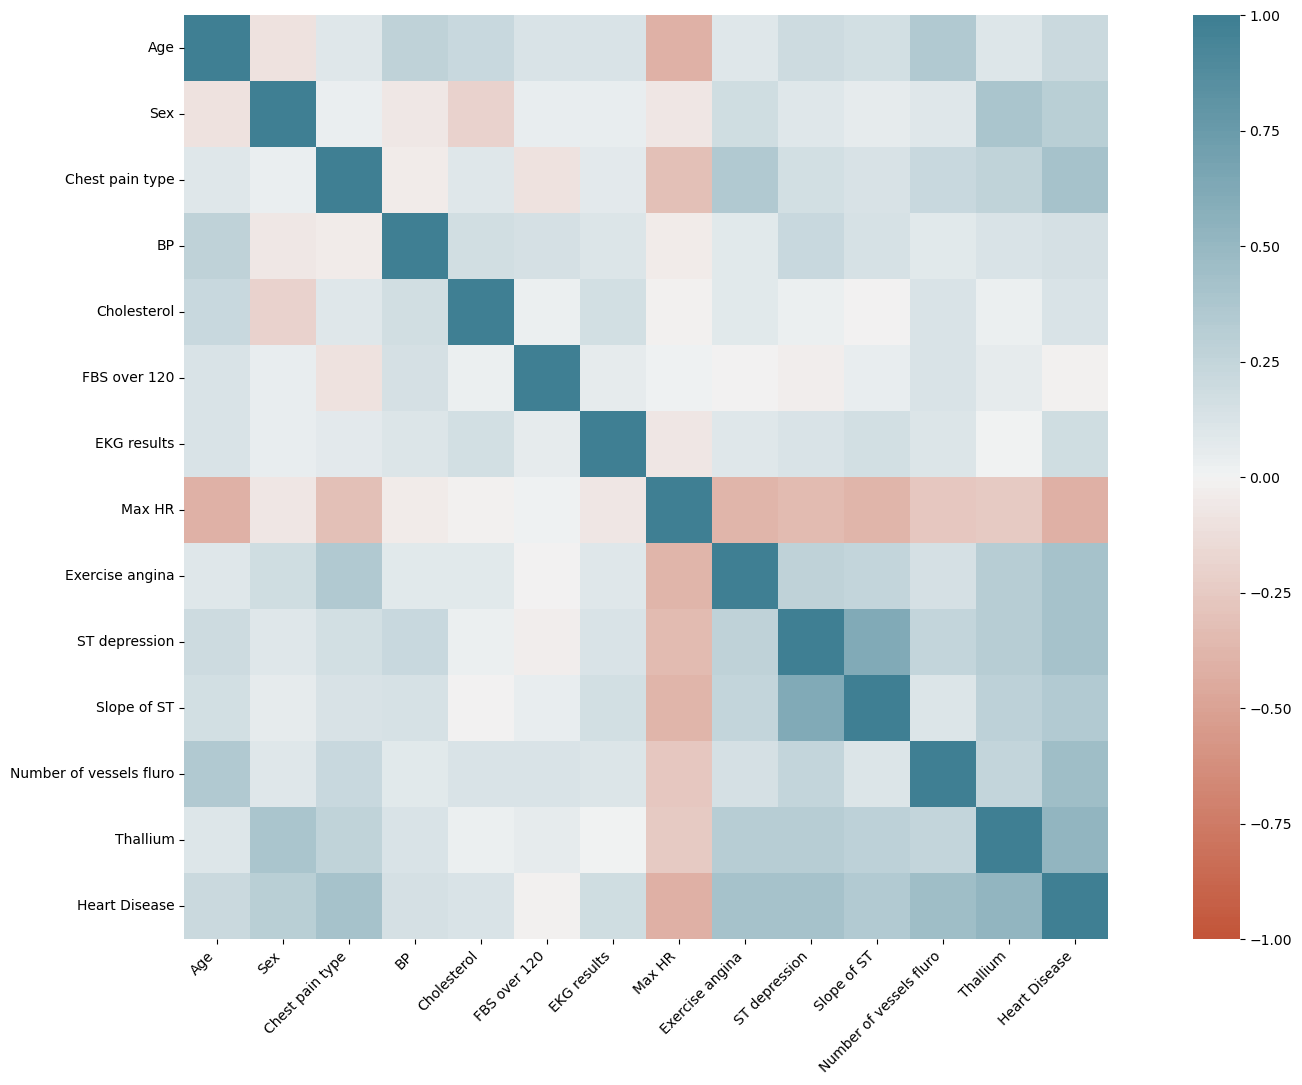

In [21]:
corr = df.corr() 

plt.figure(figsize=(22,12))
ax = sns.heatmap(corr,
                 vmin=-1,
                 vmax=1,
                 center=0,
                 cmap=sns.diverging_palette(20, 220, n=200),
                 square=True)

ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right')

plt.show()

Division train / test

In [22]:
df_X = df.drop(TARGET, axis = 1)
df_y = df[[TARGET]]

In [23]:
kfold = KFold(n_splits = 10, shuffle = True) # por defecto shuffle es False

LIST_SCORES = []

for train_idx, val_idx in kfold.split(df_X, df_y):
    
    X_train_ = df_X.iloc[train_idx]
    y_train_ = df_y.iloc[train_idx]
    
    X_val_ = df_X.iloc[val_idx]
    y_val_ = df_y.iloc[val_idx]
    
    dt=DecisionTreeClassifier() # nuevo modelo en cada iteracción
    
    dt.fit(X_train_, y_train_)
    pred_ = dt.predict(X_val_)
    
    score_ = accuracy_score(y_true = y_val_, y_pred = pred_)
    LIST_SCORES.append(score_)

In [24]:
LIST_SCORES

[0.7777777777777778,
 0.8148148148148148,
 0.8148148148148148,
 0.8148148148148148,
 0.6666666666666666,
 0.5925925925925926,
 0.6296296296296297,
 0.9259259259259259,
 0.7407407407407407,
 0.7777777777777778]

Vemos que en algunos casos, el score que obtengo es muy bajo y en otros muy alto. Todo esto tiene que ver con el split que hago de mi dataset en cada iteración.

In [25]:
np.mean(LIST_SCORES)

0.7555555555555555

In [26]:

model=DecisionTreeClassifier()

In [27]:
# Para hacer esta búsqueda lo más eficiente posible, debemos definir un espacio de parámetros a explorar.

# Para ello sklearn nos exige definir un diccionar que será nuestro param_grid.

# Diccionario con los parámetros de nuestro pipeline.


criterion=["gini", "entropy"]
max_depth= np.arange(2, 4)
min_samples_split= [3, 5, 10, 15, 20]
rf_grid = dict(criterion=criterion,max_depth=max_depth,min_samples_split=min_samples_split)

In [28]:
cv = RepeatedKFold() #Repeats K-Fold n times with different randomization in each repetition

In [29]:
# La búsqueda de nuestro mejor modelo lo vamos a hacer con RandomizedSearchCV que explora sólo algunas 
# combinaciones de nuestro param_grid y también con GridSearchCV que explora todas las posibilidades.



rand_cv = RandomizedSearchCV(
    estimator = model, 
    param_distributions = rf_grid,  
    cv = cv,
    return_train_score = True,
    verbose = False,
    n_jobs = -1
)


In [30]:
rand_cv.fit(df_X, df_y)


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=None),
                   estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([2, 3]),
                                        'min_samples_split': [3, 5, 10, 15,
                                                              20]},
                   return_train_score=True, verbose=False)

In [31]:
score_rand = rand_cv.score(df_X, df_y)


In [32]:
score_rand

0.8555555555555555

In [33]:
grid_cv = GridSearchCV(
    estimator = model, 
    param_grid = rf_grid,
    cv = cv,
    return_train_score = True,
    verbose = False,
    n_jobs = -1
)



In [34]:
grid_cv.fit(df_X, df_y)
score_grid = grid_cv.score(df_X, df_y)

In [35]:
pd.concat(
    [
        pd.DataFrame(
            data = list(rand_cv.best_params_.values()) + [round(score_rand, 3)], 
            index = list(rand_cv.best_params_.keys()) + ["Score"],
            columns = ["RandomizedSearchCV"]
        ),
        
        pd.DataFrame(
            data = list(grid_cv.best_params_.values()) + [round(score_grid, 3)], 
            index = list(grid_cv.best_params_.keys()) + ["Score"],
            columns = ["GridSearchCV"]
        ),
    ],
    axis = 1
)

RandomizedSearchCV GridSearchCV
min_samples_split                 20            5
max_depth                          3            3
criterion                    entropy         gini
Score                          0.856        0.863